In [60]:
from sklearn import datasets
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
import scipy
import numpy as np

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
iris = datasets.load_iris()
iris_X = iris.data

### Gap Statistics
$n_r = |C_r|$ (cardinalidade do cluster r)

$D_r = \sum_{i,i'\epsilon C_r}{d_{i,i'}}$ (pairwise-distance entre todos os elementos de um cluster)

$W_k = \sum_{r=1}^{k}{\frac{1}{2n_r}D_r}$ (média ponderada da soma das distâncias dentro de cada cluster - pooled within-cluster sum around the cluster means)

A ideia não é escolher a quantidade de clusters que minimiza a distância interna, pois esse sempre diminui conforme aumentamos o número de clusters. A estatística busca encontrar o valor que minimiza essa distância quando comparado a uma distribuição de referência dos dados. (Ou seja, a quantidade de clusters que mais faz diferença pela clusterização e não pelo fato de estamos aumentando o número de clusters)

$Gap_n(k) = E^*\{log(W_k)\} - log(W_k)$ (onde $E^*$ é o valor esperado de uma amostra de tamanho $n$ da distribuição de referência. O valor estimado $\widehat{k}$ é o valor que maximiza o $Gap_n(k)$ depois de levar em consideração a distribuição.

In [280]:
def calculate_wk(X, y, distance='euclidean'):
    """ Calculate nr, dr and wk """
    min_k = np.array(y).min()
    max_k = np.array(y).max()
    wk = []
    
    for i in range(min_k, max_k+1):
        # Calculate Dr for each cluster
        obs_idx = np.where(clusters == i)[0]
        nr = obs_idx.shape[0]
        
        # Get pairwise distance
        dist = pdist(X[obs_idx], distance).sum()
        
        # Calculate Wk
        wki = dist/(2*nr)
        wk.append(wki)
    
    return np.array(wk).sum()

def get_clusters(X, k, mode='hierarquical', **kwargs):
    """ Different clustering modes. """
    if mode == 'hierarquical':
        # Create linkage matrix for original data
        Z = hierarchy.linkage(X, **kwargs)
        clusters = hierarchy.fcluster(Z, k, criterion='maxclust')    
    elif mode == 'kmeans':
        clusters = KMeans(n_clusters=k).fit_predict(X)
    return clusters

### Prepare reference dataset

In [281]:
nrefs = 20
shape = iris_X.shape
# Set bounding box
tops = iris_X.max(axis=0)
bots = iris_X.min(axis=0)

# Generate distribution
rands = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))

# Set offset for random uniform samples to be inside bounding boxes
dists = scipy.matrix(scipy.diag(tops-bots))
for i in range(nrefs):
    rands[:,:,i] = rands[:,:,i]*dists+bots

#### Clustering using hierarchy

In [282]:
k_max = 6

In [283]:
def calculate_gap(X):
    gaps = []
    error = []
    for k in range(2,k_max+1):
        # Calculate Wk for original data
        clusters = get_clusters(iris_X, k, 'kmeans', method='ward')
        wk = calculate_wk(iris_X, clusters)
        log_wk = np.log(wk)

        # Calculate Wk for reference distribution
        wk_refs = []
        for ref in range(nrefs):
            clusters = get_clusters(rands[:,:,ref], k, 'kmeans', method='ward')
            wk_ref = calculate_wk(rands[:,:,ref], clusters)
            log_wk_ref = np.log(wk_ref)
            wk_refs.append(log_wk_ref)
        wkb = np.array(wk_refs)
        wkb_sum = wkb.sum()
        wkb_std = wkb.std()
        B = wkb.shape[0]

        # Calculate Gap
        gap_k = (1/B*wkb_sum) - log_wk
        gaps.append(gap_k)
        error.append(np.sqrt(wkb_std*(1+(1/B))))

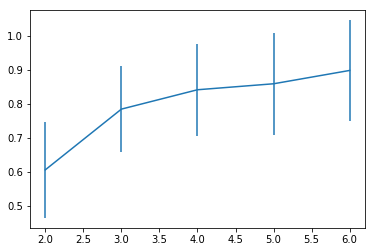

In [272]:
plt.errorbar(list(range(2,k_max+1)), gaps, yerr=error)
plt.show()

In [273]:
gaps

[0.6052640869429742,
 0.78402758524008,
 0.8410192386422226,
 0.8586295186768358,
 0.8978649080418863]

In [274]:
error

[0.14150127977566185,
 0.12734768668005902,
 0.13552250234911448,
 0.15010269775133062,
 0.14776678260009585]

In [275]:
for i in range(2,k_max):
    k = i-2
    gapi = gaps[k]
    gapi1 = gaps[k+1]
    std = error[k+1]
    if gapi >= (gapi1-std):
        print("k = %d" % (k+2))
        break

k = 3
